In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import io

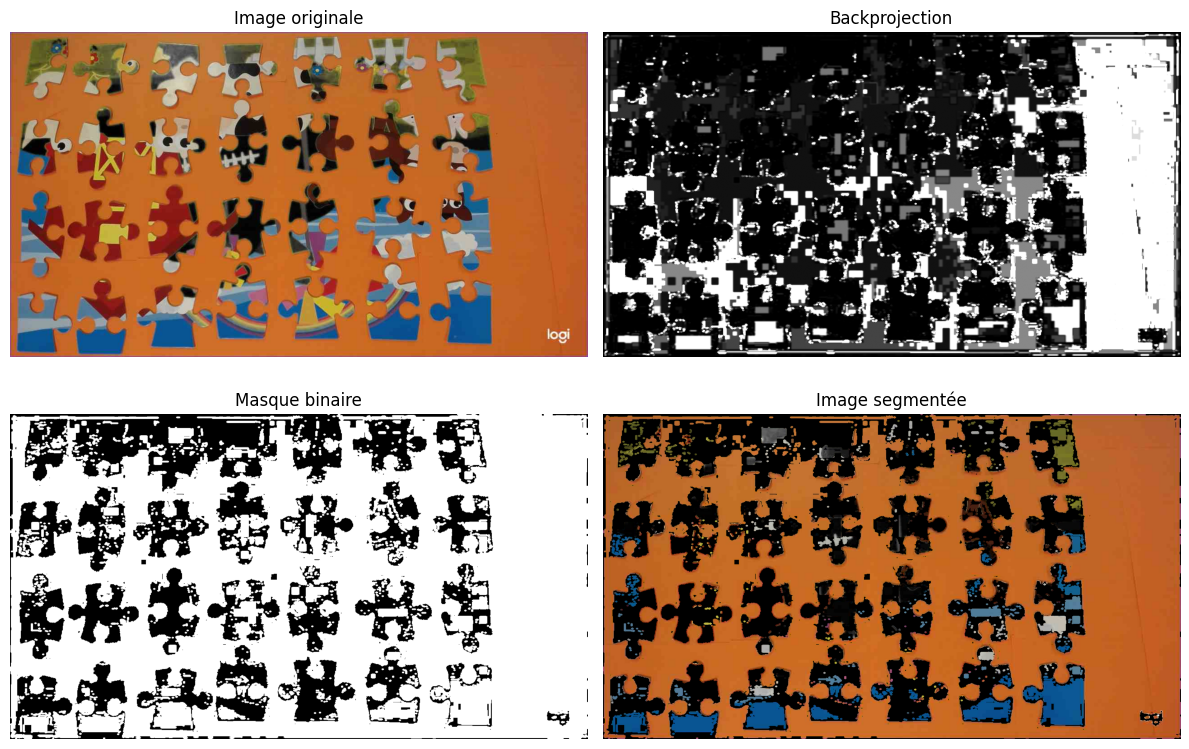

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image and convert to HSV
img = cv2.imread('img-011.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # For matplotlib
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# --- 1. Select ROI manually or hardcode ---
x, y, w, h = 1000, 0, 1100, 700
roi = hsv[y:y+h, x:x+w]

# --- 2. Compute histogram on H and S channels ---
roi_hist = cv2.calcHist([roi], [0, 1], None, [180, 256], [0, 180, 0, 256])
cv2.normalize(roi_hist, roi_hist, 0, 255, cv2.NORM_MINMAX)

# --- 3. Apply backprojection ---
backproj = cv2.calcBackProject([hsv], [0, 1], roi_hist, [0, 180, 0, 256], 1)

# --- 4. Filter and threshold ---
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
backproj = cv2.filter2D(backproj, -1, kernel)

_, mask = cv2.threshold(backproj, 0, 255, cv2.THRESH_BINARY)

# --- 5. Apply mask to original image ---
result = cv2.bitwise_and(img, img, mask=mask)
result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

# --- 6. Plot with matplotlib ---
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[0, 0].imshow(img_rgb)
axs[0, 0].set_title("Image originale")
axs[0, 0].axis('off')

axs[0, 1].imshow(backproj, cmap='gray')
axs[0, 1].set_title("Backprojection")
axs[0, 1].axis('off')

axs[1, 0].imshow(mask, cmap='gray')
axs[1, 0].set_title("Masque binaire")
axs[1, 0].axis('off')

axs[1, 1].imshow(result_rgb)
axs[1, 1].set_title("Image segmentée")
axs[1, 1].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
img.shape


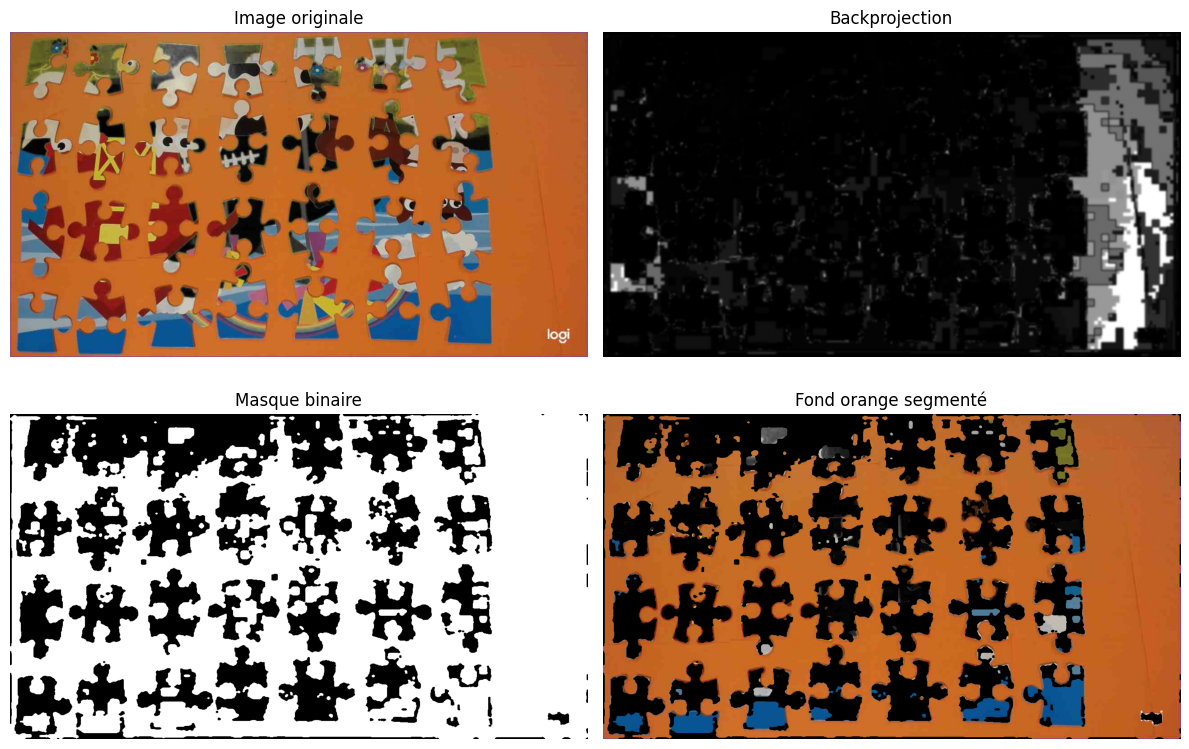

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load and convert to RGB (for matplotlib) and HSV (for processing)
img_bgr = cv2.imread("img-011.jpg")
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

# 1. Select a region of orange background (top-left area for example)
x, y, w, h = 1000, 0, 1279, 700 # make sure it’s on orange
roi = hsv[y:y+h, x:x+w]

# 2. Compute histogram on H and S channels
roi_hist = cv2.calcHist([roi], [0, 1], None, [180, 256], [0, 180, 0, 256])
cv2.normalize(roi_hist, roi_hist, 0, 255, cv2.NORM_MINMAX)

# 3. Backprojection on full image
backproj = cv2.calcBackProject([hsv], [0, 1], roi_hist, [0, 180, 0, 256], 1)

# 4. Smooth and threshold
backproj = cv2.GaussianBlur(backproj, (11, 11), 0)
_, mask = cv2.threshold(backproj, 0, 255, cv2.THRESH_BINARY)

# 5. Clean mask (optional)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# 6. Apply mask to original image
segmented = cv2.bitwise_and(img_rgb, img_rgb, mask=mask)

# 7. Plot results
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[0, 0].imshow(img_rgb)
axs[0, 0].set_title("Image originale")
axs[0, 0].axis('off')

axs[0, 1].imshow(backproj, cmap='gray')
axs[0, 1].set_title("Backprojection")
axs[0, 1].axis('off')

axs[1, 0].imshow(mask, cmap='gray')
axs[1, 0].set_title("Masque binaire")
axs[1, 0].axis('off')

axs[1, 1].imshow(segmented)
axs[1, 1].set_title("Fond orange segmenté")
axs[1, 1].axis('off')

plt.tight_layout()
plt.show()


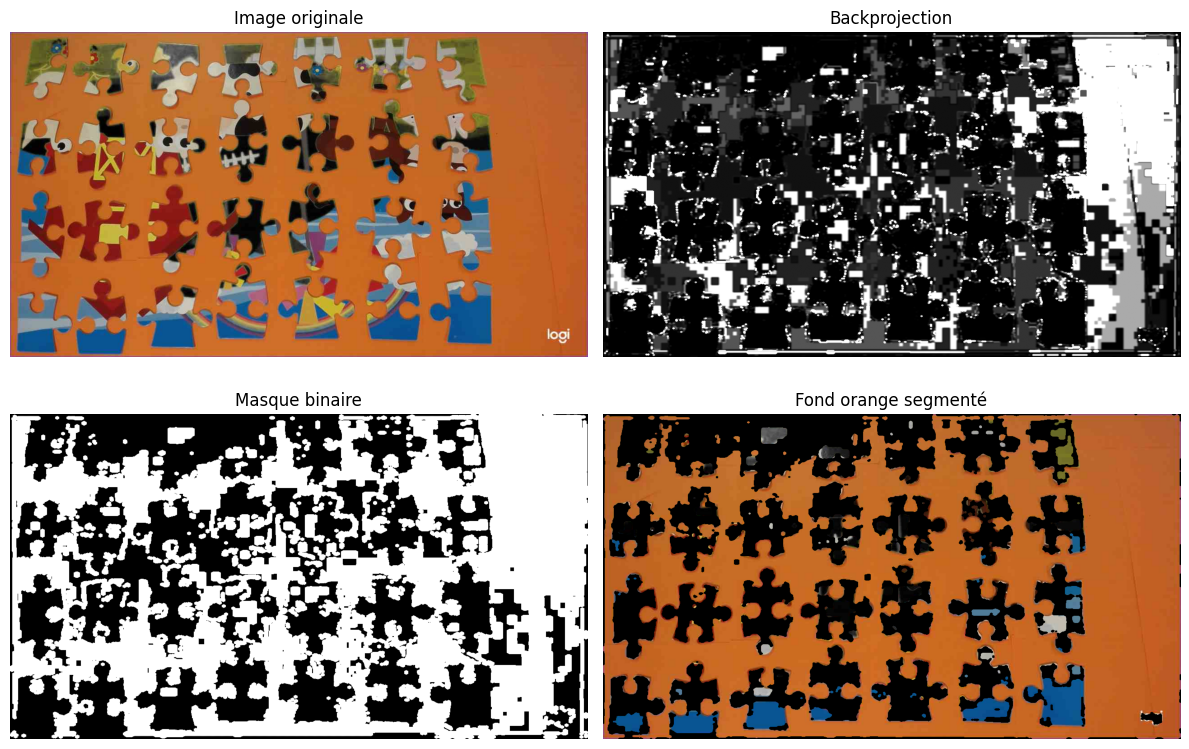

In [4]:

import cv2

# Load grayscale
img = cv2.imread('img-011.jpg')

# --- 1. Select ROI manually or hardcode ---
x, y, w, h = 1000, 0, 1279, 300
roi = hsv[y:y+h, x:x+w]

# --- 2. Compute histogram on H and S channels ---
roi_hist = cv2.calcHist([roi], [0, 1], None, [180, 256], [0, 180, 0, 256])
cv2.normalize(roi_hist, roi_hist, 0, 255, cv2.NORM_MINMAX)

# --- 3. Apply backprojection ---
backproj = cv2.calcBackProject([hsv], [0, 1], roi_hist, [0, 180, 0, 256], 1)

# --- 4. Filter and threshold ---
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
backproj = cv2.filter2D(backproj, -1, kernel)

_, mask = cv2.threshold(backproj, 20, 255, cv2.THRESH_BINARY)

# --- NEW STEP: Clean mask using morphology ---

# Step 1: remove small white noise
clean = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

# Step 2: fill small holes inside the puzzle pieces
clean = cv2.morphologyEx(clean, cv2.MORPH_CLOSE, kernel)

# Optional: smooth edges slightly
clean = cv2.dilate(clean, kernel, iterations=1)

# Step 6: Remove small components
import numpy as np

# Minimum size of a puzzle piece (in pixels) — adjust as needed
min_area = 1000

# Connected components (returns num_labels, label map, stats, centroids)
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(clean)

# Create a blank mask to hold only large components
final_mask = np.zeros_like(clean)

# Loop through all components (label 0 is background)
for i in range(1, num_labels):
    area = stats[i, cv2.CC_STAT_AREA]
    if area > min_area:
        final_mask[labels == i] = 255


# --- 5. Apply mask to original image ---
result = cv2.bitwise_and(img, img, mask=final_mask)
result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)


# 7. Plot results
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[0, 0].imshow(img_rgb)
axs[0, 0].set_title("Image originale")
axs[0, 0].axis('off')

axs[0, 1].imshow(backproj, cmap='gray')
axs[0, 1].set_title("Backprojection")
axs[0, 1].axis('off')

axs[1, 0].imshow(clean, cmap='gray')
axs[1, 0].set_title("Masque binaire")
axs[1, 0].axis('off')

axs[1, 1].imshow(segmented)
axs[1, 1].set_title("Fond orange segmenté")
axs[1, 1].axis('off')

plt.tight_layout()
plt.show()

## On doit utiliser plusieurs regions 



Select BACKGROUND ROIs. Press ENTER after each one. ESC when done.
Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!


2025-05-22 17:30:41.186 Python[29578:7753339] +[IMKClient subclass]: chose IMKClient_Modern
2025-05-22 17:30:41.186 Python[29578:7753339] +[IMKInputSession subclass]: chose IMKInputSession_Modern


Background ROI added.
Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!
Background ROI added.
Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!
Background ROI added.
Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!
Background ROI added.
Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!
Background ROI added.
Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!
Background ROI added.
Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!
Background ROI added.
Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!
Background ROI added.
Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!
Backgrou

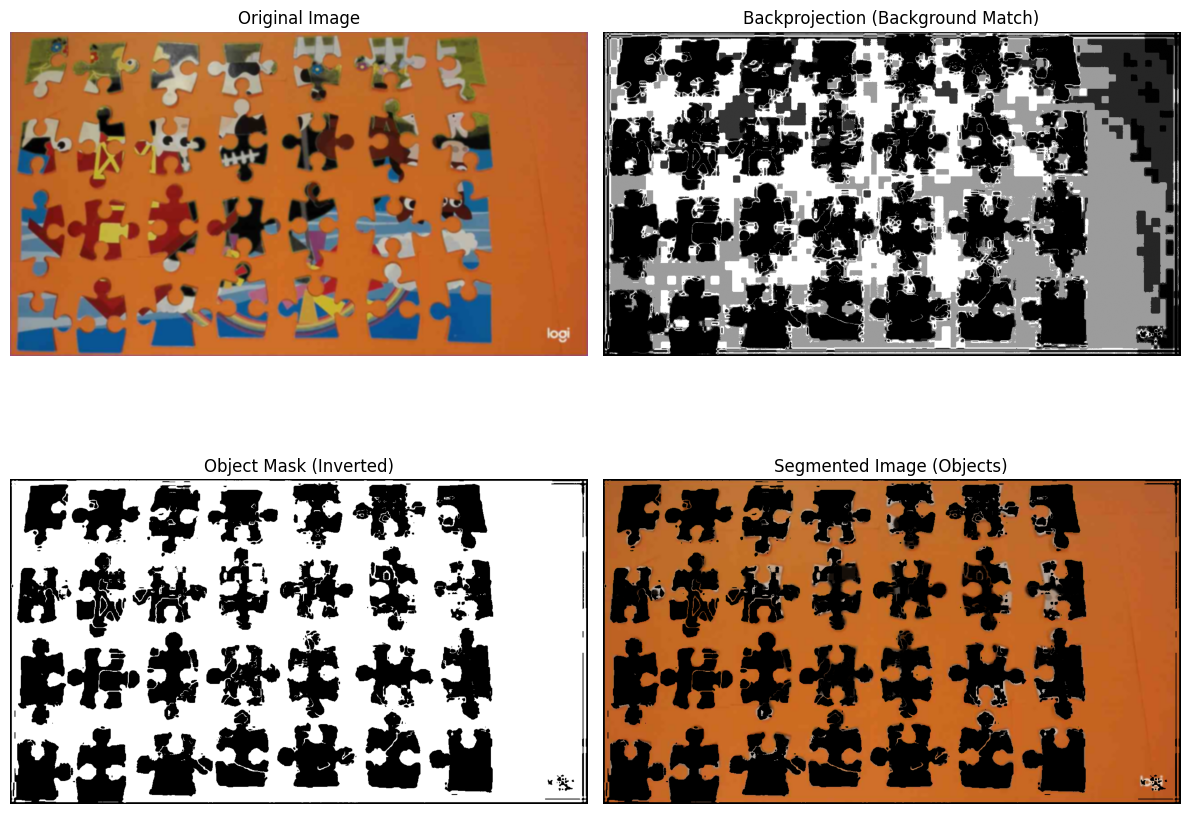

In [5]:
import cv2
import numpy as np

# Load image and convert to HSV
img = cv2.imread("img-011.jpg")
#img = egalisationLuminanceLab(img)
img = cv2.GaussianBlur(img, (7, 7), 0)
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


# Step 1: Select background ROIs with the mouse
print("Select BACKGROUND ROIs. Press ENTER after each one. ESC when done.")
background_rois = []

while True:
    r = cv2.selectROI("Select Background ROI", img, fromCenter=False, showCrosshair=True)
    if r == (0, 0, 0, 0):
        break
    roi = hsv[int(r[1]):int(r[1]+r[3]), int(r[0]):int(r[0]+r[2])]
    background_rois.append(roi)
    print("Background ROI added.")
cv2.destroyAllWindows()

# Step 2: Combine background histograms
bg_hist = None
for roi in background_rois:
    h = cv2.calcHist([roi], [0], None, [180], [0, 180])  
    bg_hist = h if bg_hist is None else bg_hist + h

cv2.normalize(bg_hist, bg_hist, 0, 255, cv2.NORM_MINMAX)



# Backprojection
backproj = cv2.calcBackProject([hsv], [0], bg_hist, [0, 180], 1)

backproj = cv2.normalize(backproj, None, 0, 255, cv2.NORM_MINMAX)



# Threshold to detect background
_, background_mask = cv2.threshold(backproj, 0, 255, cv2.THRESH_BINARY_INV)

# Invert mask to get object regions
object_mask = cv2.bitwise_not(background_mask)

# Apply mask to original image
segmented = cv2.bitwise_and(img, img, mask=object_mask)
segmented_rgb = cv2.cvtColor(segmented, cv2.COLOR_BGR2RGB)

# Display everything with matplotlib
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0, 0].imshow(img_rgb)
axs[0, 0].set_title("Original Image")
axs[0, 0].axis('off')

axs[0, 1].imshow(backproj, cmap='gray')
axs[0, 1].set_title("Backprojection (Background Match)")
axs[0, 1].axis('off')

axs[1, 0].imshow(object_mask, cmap='gray')
axs[1, 0].set_title("Object Mask (Inverted)")
axs[1, 0].axis('off')

axs[1, 1].imshow(segmented_rgb)
axs[1, 1].set_title("Segmented Image (Objects)")
axs[1, 1].axis('off')

plt.tight_layout()
plt.show()

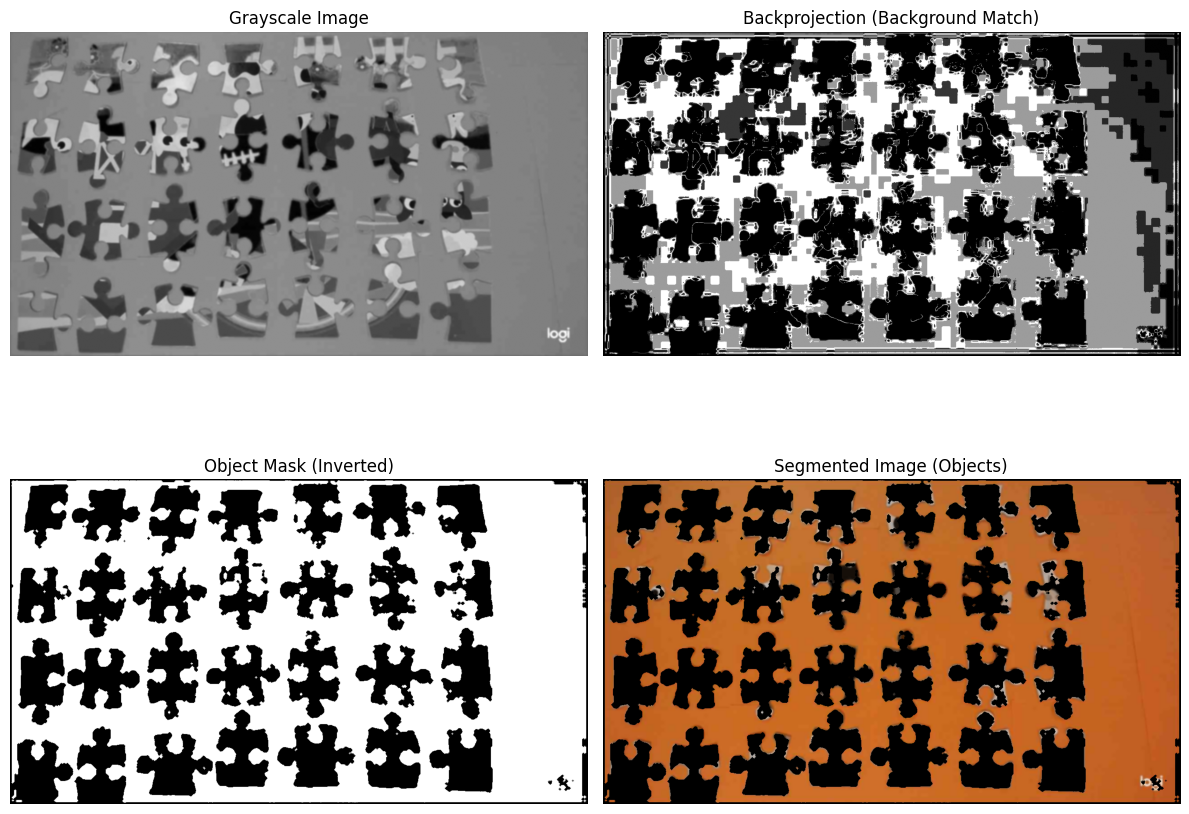

In [6]:
# Threshold to detect background
_, background_mask = cv2.threshold(backproj, 0, 255, cv2.THRESH_BINARY_INV)

# Invert mask to get object regions
object_mask = cv2.bitwise_not(background_mask)

# === Clean object mask using morphology ===
kernel = cv2.getStructuringElement(cv2.MORPH_DILATE, (5, 5))

#Remove small white noise (tiny false object pixels)
object_mask = cv2.morphologyEx(object_mask, cv2.MORPH_OPEN, kernel)

# Fill holes inside the puzzle pieces
object_mask = cv2.morphologyEx(object_mask, cv2.MORPH_CLOSE, kernel)


img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply mask to original image
segmented = cv2.bitwise_and(img, img, mask=object_mask)
segmented_rgb = cv2.cvtColor(segmented, cv2.COLOR_BGR2RGB)

# Display everything with matplotlib
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0, 0].imshow(img_gray, cmap='gray')
axs[0, 0].set_title("Grayscale Image")
axs[0, 0].axis('off')

axs[0, 1].imshow(backproj, cmap='gray')
axs[0, 1].set_title("Backprojection (Background Match)")
axs[0, 1].axis('off')

axs[1, 0].imshow(object_mask, cmap='gray')
axs[1, 0].set_title("Object Mask (Inverted)")
axs[1, 0].axis('off')

axs[1, 1].imshow(segmented_rgb)
axs[1, 1].set_title("Segmented Image (Objects)")
axs[1, 1].axis('off')

plt.tight_layout()
plt.show()



## A ce moment la, j'ai remarque que je peux utiliser l'image gris comme la base deuxieme mask binaire. L'idee est d'utiliser mask crée a partir de l'image gris, seulement en pixels qui est blanche. Avec ce technique, on peut remplir des trous.


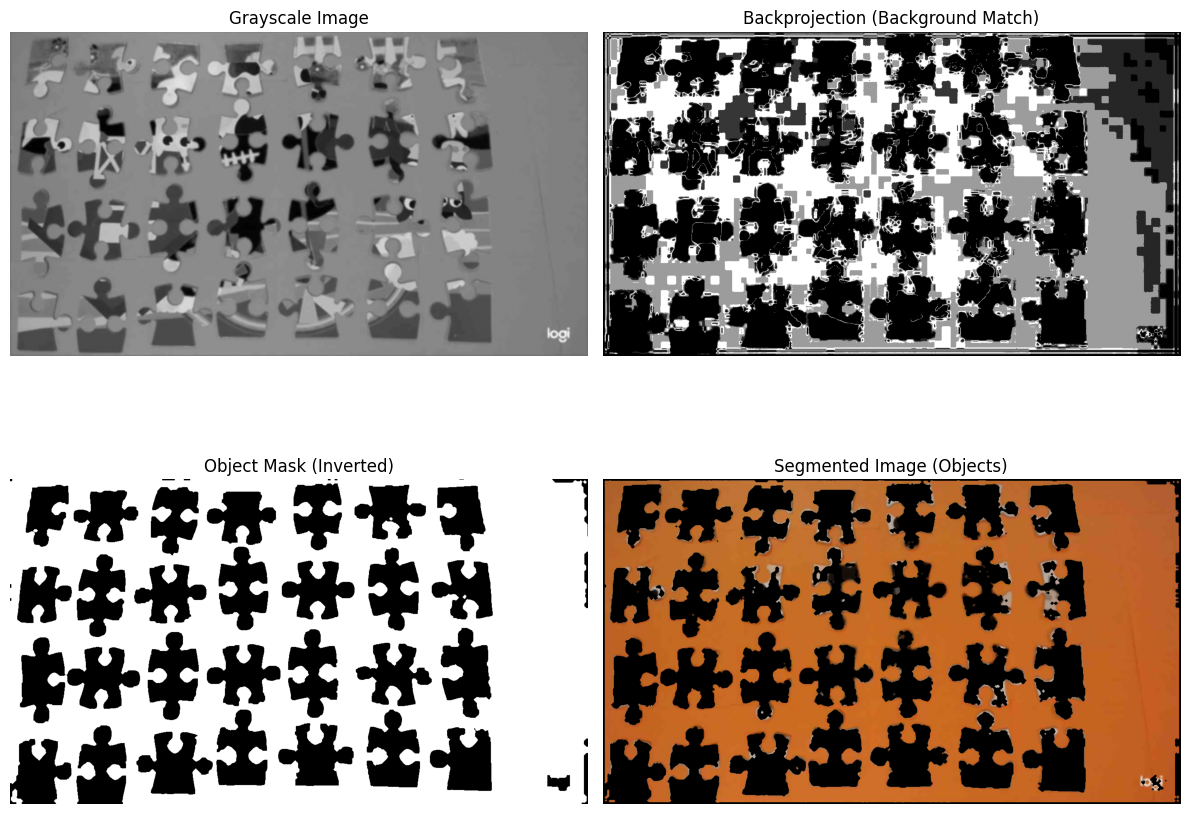

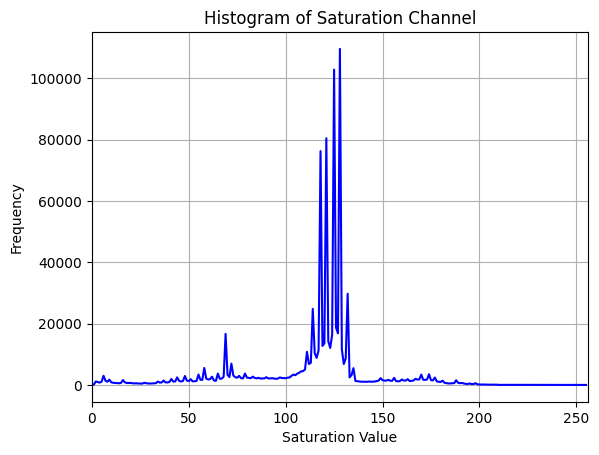

In [7]:
import cv2
import numpy as np

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


# Assuming refined_mask is your binary mask (dtype=uint8, values 0 or 255)
kernel_er = cv2.getStructuringElement(cv2.MORPH_ERODE, (3, 3))  # You can change size/shape
kernel_dil = cv2.getStructuringElement(cv2.MORPH_DILATE, (3, 3))  # You can change size/shape
new_mask = cv2.dilate(object_mask, kernel_dil, iterations=4)



# Refine using grayscale
refined_mask = new_mask.copy()
threshold_min = 100  # e.g., too dark? remove
threshold_max = 140  # e.g., too bright? remove

# Loop-free version: apply gray threshold only on white pixels in hue_mask
mask_white = (new_mask == 255)
gray_out_of_range = (gray < threshold_min) | (gray > threshold_max)
refined_mask[mask_white & gray_out_of_range] = 0


# Fill holes inside the puzzle pieces
refined_mask = cv2.erode(refined_mask, kernel_er, iterations=3)
refined_mask = cv2.dilate(refined_mask, kernel_dil, iterations=3)




# Display everything with matplotlib
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0, 0].imshow(img_gray, cmap='gray')
axs[0, 0].set_title("Grayscale Image")
axs[0, 0].axis('off')

axs[0, 1].imshow(backproj, cmap='gray')
axs[0, 1].set_title("Backprojection (Background Match)")
axs[0, 1].axis('off')

axs[1, 0].imshow(refined_mask, cmap='gray')
axs[1, 0].set_title("Object Mask (Inverted)")
axs[1, 0].axis('off')

axs[1, 1].imshow(segmented_rgb)
axs[1, 1].set_title("Segmented Image (Objects)")
axs[1, 1].axis('off')

plt.tight_layout()
plt.show()

# Plot histogram for Saturation channel
hist_sat = cv2.calcHist([gray], [0], None, [256], [0, 256])
plt.figure()
plt.title("Histogram of Saturation Channel")
plt.xlabel("Saturation Value")
plt.ylabel("Frequency")
plt.plot(hist_sat, color='blue')
plt.xlim([0, 256])
plt.grid()
plt.show()


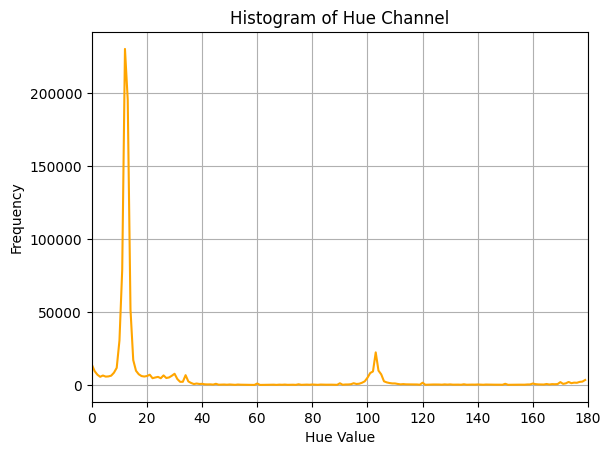

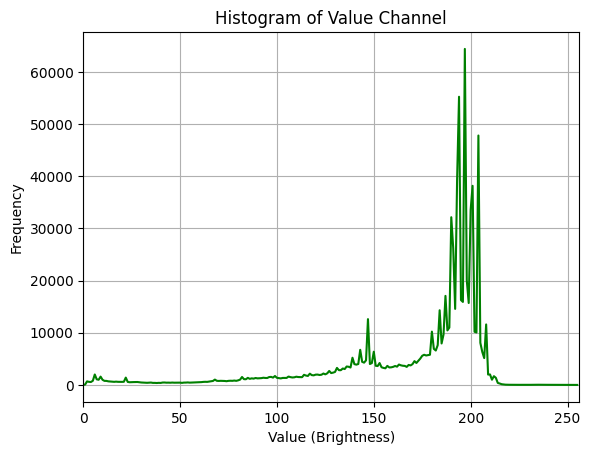

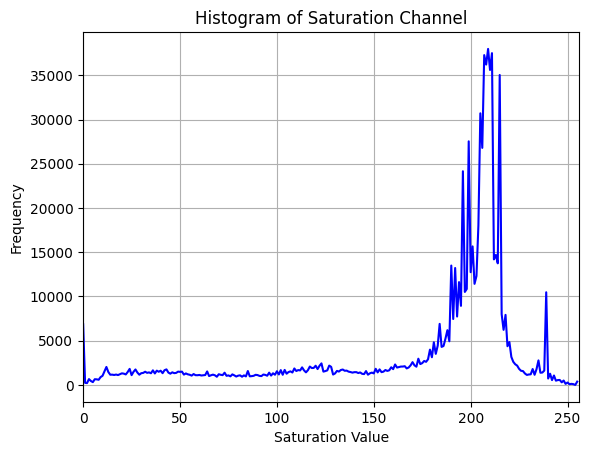

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

hue, sat, val = cv2.split(hsv)

# Step 2: Calculate mean and standard deviation on Hue
mu = np.mean(hue)
sigma = np.std(hue)

# Step 3: Choose sensitivity parameter alpha
alpha = 0.8 # try values between 0.6 and 1.5

# Step 4: Thresholding
lower = mu - alpha * sigma
upper = mu + alpha * sigma

# Use wrapping in hue values if needed (Hue is circular in range 0–180 for OpenCV)
binary_mask = np.where((hue >= lower) & (hue <= upper), 255, 0).astype(np.uint8)

# Optional: Invert it so pieces are black on white (or leave as is depending on needs)
inverted_mask = 255 - binary_mask


# Calculate the histogram of the hue channel
hist = cv2.calcHist([hue], [0], None, [180], [0, 180])

# Plot the histogram
plt.figure()
plt.title("Histogram of Hue Channel")
plt.xlabel("Hue Value")
plt.ylabel("Frequency")
plt.plot(hist, color='orange')
plt.xlim([0, 180])
plt.grid()
plt.show()

# Plot histogram for Value (Brightness) channel
hist_val = cv2.calcHist([val], [0], None, [256], [0, 256])
plt.figure()
plt.title("Histogram of Value Channel")
plt.xlabel("Value (Brightness)")
plt.ylabel("Frequency")
plt.plot(hist_val, color='green')
plt.xlim([0, 256])
plt.grid()
plt.show()

# Plot histogram for Saturation channel
hist_sat = cv2.calcHist([sat], [0], None, [256], [0, 256])
plt.figure()
plt.title("Histogram of Saturation Channel")
plt.xlabel("Saturation Value")
plt.ylabel("Frequency")
plt.plot(hist_sat, color='blue')
plt.xlim([0, 256])
plt.grid()
plt.show()


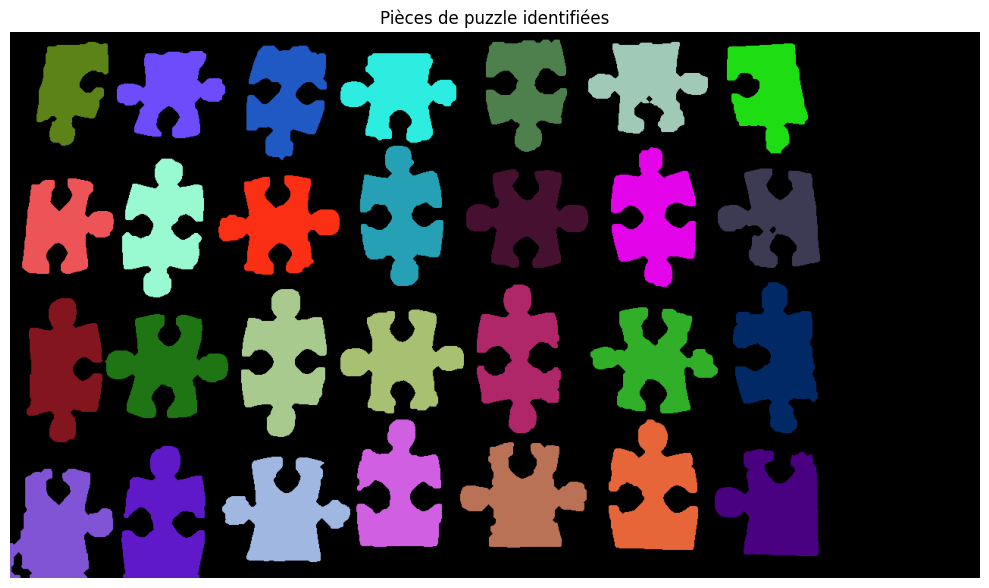

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os


# === 2. Invert it so that pieces become white (foreground) ===
mask_inv = cv2.bitwise_not(refined_mask)

# === 3. Clean it using morphology (to remove holes/noise) ===
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
cleaned = cv2.morphologyEx(mask_inv, cv2.MORPH_CLOSE, kernel)  # fill small holes
cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_OPEN, kernel)    # remove tiny dots

# === 4. Connected Component Analysis ===
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(cleaned)

# === 5. Prepare colored output image ===
output = np.zeros((labels.shape[0], labels.shape[1], 3), dtype=np.uint8)
colors = np.random.randint(0, 255, size=(num_labels, 3))

# Optional: minimum area to ignore noise
min_area = 2000


for i in range(1, num_labels):  # skip label 0 (background)
    area = stats[i, cv2.CC_STAT_AREA]
    if area > min_area:
        output[labels == i] = colors[i]

# === 6. Show the result ===
plt.figure(figsize=(10, 6))
plt.imshow(output)
plt.title("Pièces de puzzle identifiées")
plt.axis('off')
plt.tight_layout()
plt.show()

# === 7. Optional: Extract and save each piece ===
# Use the already loaded image (img) as the original image
original_img = img
os.makedirs("extracted_pieces", exist_ok=True)


puzzle_pieces = {}
n = 0
for i in range(1, num_labels):
    area = stats[i, cv2.CC_STAT_AREA]
    if area > min_area:
        x, y, w, h = stats[i, cv2.CC_STAT_LEFT], stats[i, cv2.CC_STAT_TOP], \
                     stats[i, cv2.CC_STAT_WIDTH], stats[i, cv2.CC_STAT_HEIGHT]
        mask_piece = (labels == i).astype("uint8") * 255
        piece_mask = mask_piece[y:y+h, x:x+w]
        piece_img = original_img[y:y+h, x:x+w]
        piece_masked = cv2.bitwise_and(piece_img, piece_img, mask=piece_mask)

        # Save to dictionary
        puzzle_pieces[n] = {
            "bounding_box": (x, y, w, h),
            "mask": piece_mask,
            "image": piece_masked,
            "area": area
        }
        n += 1

        cv2.imwrite(f"extracted_pieces/piece_{i}.png", piece_masked)


In [10]:
puzzle_pieces.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27])

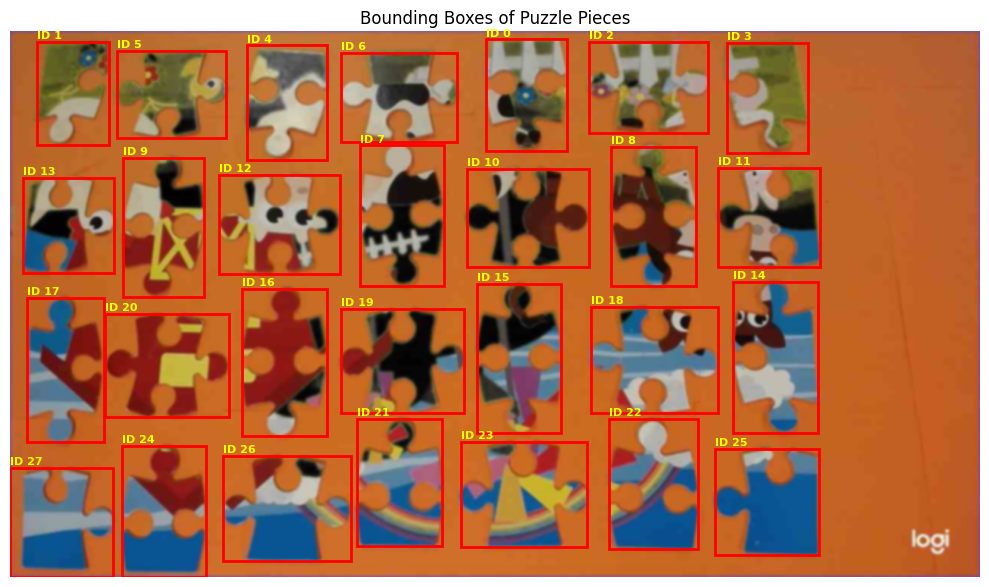

In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Show original image
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB

# Draw bounding boxes
for idx, piece in puzzle_pieces.items():
    x, y, w, h = piece["bounding_box"]
    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    ax.text(x, y - 5, f"ID {idx}", color='yellow', fontsize=8, weight='bold')

plt.title("Bounding Boxes of Puzzle Pieces")
plt.axis('off')
plt.tight_layout()
plt.show()


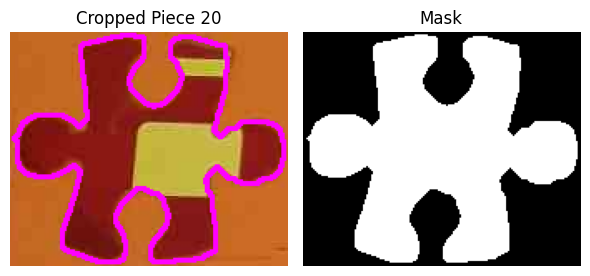

In [12]:
import matplotlib.pyplot as plt
import cv2

# Choose a piece ID you want to visualize
piece_id = 20

# Access the original image (make sure it's defined)
# original_img = cv2.imread("your_original_image.png")  # If not already loaded
# Convert it to RGB if needed for display
original_bgr = cv2.imread("/Users/monsieurerkan/Desktop/INF3056L/Images/img-011.jpg")
original_rgb = cv2.cvtColor(original_bgr, cv2.COLOR_BGR2RGB)

# Get bounding box values
x, y, w, h = puzzle_pieces[piece_id]["bounding_box"]

y_down = y
y_up = y + h
x_down = x
x_up = x + w

if (y_down - 2 >= 0):
    y_down = y - 2

if (y_up + 2 < original_rgb.shape[0]):
    y_up = y_up + 2

if (x_down - 2 >= 0):
    x_down = x - 2

if (x_up + 2 < original_rgb.shape[1]):
    x_up = x_up + 2

# Crop the piece using the bounding box
cropped_image = original_rgb[y_down:y_up, x_down:x_up]
cropped_mask = cleaned[y_down:y_up, x_down:x_up]

# === 1. Find the full contour
contours, _ = cv2.findContours(cropped_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(cropped_image, contours, -1, (255, 0, 255), 2)  # Magenta full contour


# Plot
plt.figure(figsize=(6, 4))
plt.subplot(1, 2, 1)
plt.imshow(cropped_image)
plt.title(f"Cropped Piece {piece_id}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cropped_mask, cmap='gray')
plt.title("Mask")
plt.axis('off')

plt.tight_layout()
plt.show()
